# Goal
* project rotated ellipsoid

# imports

In [180]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import tensor

# $x^TQx$
* check equations from https://math.stackexchange.com/questions/573055/projection-of-ellipsoid
  * $C = (PQ^{-1}P^T)^{-1}$
* Q is the equation of the (roated) elipse in 3D
* consider the elipse: $x^2 + y^2 + xy + z^2 = 1$
  * we get this parametric form from $x^TQx$
  * when we rotate a point, we get $(Rx)^TQ(Rx) = x^T (R^TQR)x$
* P is for the xy plane

In [3]:
Q = np.array([[1,-0.5,0,0],[-0.5,1,0,0],[0,0,1,0],[0,0,0,-1]])
Qinv = np.linalg.inv(Q)

In [5]:
Qinv

array([[ 1.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.66666667,  1.33333333,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [-0.        , -0.        , -0.        , -1.        ]])

In [8]:
P = np.zeros((3,4))
P[0,0] = P[1,1] = P[2,3] = 1
P

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]])

In [9]:
C = np.linalg.inv(P @ Qinv @P.T)

In [10]:
C

array([[ 1. , -0.5,  0. ],
       [-0.5,  1. ,  0. ],
       [-0. , -0. , -1. ]])

# Rotate elipse
* $1x^2 + 2y^2 + 3z^2 = 1$


## rotate 90 deg in xy plane
* rotate by 90 deg about the z axis
* rotated elipse
* note that $R^TQR$ plays the role of $Q$ in the unrotated case

In [32]:
R = np.zeros((4,4))
theta = np.deg2rad(90)
c = np.cos(theta)
s = np.sin(theta)
R[:2,:2] = np.array([[c,-s],[s,c]])
R[-1,-1] = R[-2,-2] = 1
R

array([[ 6.123234e-17, -1.000000e+00,  0.000000e+00,  0.000000e+00],
       [ 1.000000e+00,  6.123234e-17,  0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

In [33]:
Q = np.diag([1,2,3,-1])
Q

array([[ 1,  0,  0,  0],
       [ 0,  2,  0,  0],
       [ 0,  0,  3,  0],
       [ 0,  0,  0, -1]])

In [34]:
Q_rot = R.T @ Q @ R
Q_rot

array([[ 2.000000e+00,  6.123234e-17,  0.000000e+00,  0.000000e+00],
       [ 6.123234e-17,  1.000000e+00,  0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  3.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00, -1.000000e+00]])

In [35]:
Qinv = np.linalg.inv(Q_rot)
C = np.linalg.inv(P @ Qinv @P.T)

In [36]:
C

array([[ 2.000000e+00,  6.123234e-17,  0.000000e+00],
       [ 6.123234e-17,  1.000000e+00,  0.000000e+00],
       [-0.000000e+00, -0.000000e+00, -1.000000e+00]])

# Rotate about (1,1,1) vector by 45 deg

In [43]:
import pytorch3d.transforms
import torch
from torch import tensor

In [53]:
R = np.zeros((4,4))
R[:3,:3] = pytorch3d.transforms.axis_angle_to_matrix(torch.deg2rad(tensor(45.))*tensor([1,1,1])).numpy()
R[-1,-1] = 1

In [54]:
Q = np.diag([1,2,3,-1])
Q_rot = R.T @ Q @ R
Qinv = np.linalg.inv(Q_rot)
C = np.linalg.inv(P @ Qinv @P.T)
C

array([[ 1.68193036,  0.11538913,  0.        ],
       [ 0.11538913,  2.32851466,  0.        ],
       [-0.        , -0.        , -1.        ]])

# Rotate elipse in xy plane above z axis
* 1x^2 + 2y^2 + 1 = 1
* https://math.stackexchange.com/questions/73237/parametric-equation-of-a-circle-in-3d-space

# Fourier slice theorem
1. Numerically evaluate (rotated) ellipsoid on grid
2. Line integral

OR
1. Precomptue 3D FFT elipse
2. extract rotated slice (interpolate)
3. do 2D iFFT

In [17]:
import numpy as np

a = 1.0
b = 2.0
c = 3.0
nx = 256   # number of pixels in x-dir
ny = 256   # number of pixels in y-dir
nz = 256

# set up a coordinate system
x = np.linspace(-5.0, 5.0, nx)
y = np.linspace(-5.0, 5.0, ny)
z = np.linspace(-5.0, 5.0, ny)


# Setup arrays which just list the x and y coordinates
xgrid, ygrid, zgrid = np.meshgrid(x, y, z)

# Calculate the ellipse values all at once
ellipse = xgrid**2 / a**2 + ygrid**2 / b**2 + zgrid**2 / c**2

# Create an array of int32 zeros
ellipsoid = np.zeros((nx,ny, nz), dtype=np.int32)

# Put 1's where ellipse is less than 1.0
# Note ellipse <1.0 produces a boolean array that then indexes grey
ellipsoid[ellipse < 1.0] = 1

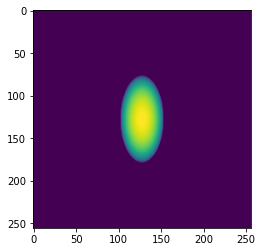

In [71]:
plt.imshow(ellipsoid.sum(-1))

In [72]:

dim3 = (1,2,3)
dim2 = (1,2)
ellipsoid_f = torch.fft.fftshift(torch.fft.fftn(torch.fft.ifftshift(tensor(ellipsoid).reshape(1,nx,ny,nz),dim=dim3), dim=dim3), dim=dim3)

In [73]:
central_slice_r = torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(ellipsoid_f[:1,:,:,nz//2],dim=dim2),dim=dim2),dim=dim2)

In [74]:
central_slice_r.real.abs().sum(), central_slice_r.imag.abs().sum()

(tensor(416520.0625), tensor(0.1178))

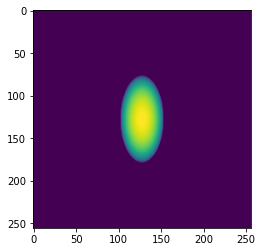

In [75]:
plt.imshow(central_slice_r[0].real)

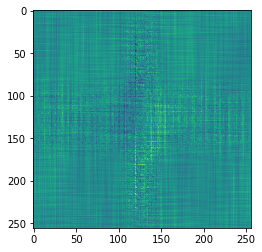

In [65]:
plt.imshow(central_slice_r[0].imag)

# Implicit -> parametric
From the implicit form for an ellipsoid, we can derive the parametric form, as a function of $z$.
$$
\frac{x^2}{a^a} + \frac{y^2}{b^2} + \frac{z^2}{c^2} = 1
\\
\implies z = \pm c \sqrt{1 - \frac{x^2}{a^a} - \frac{y^2}{b^2}}
$$

From this, we can find, for any value of x/y in the x/y plane, the value of z, which is on the surface of the ellipsoid.

Assuming the ellipsoid has constant density inside, and zero value outside, the integral is just the different of z values, above and below the x/y plane. 
* at $x=y=0$ we have $z = \pm c \sqrt{1 - 0 - 0} = \pm c$
* at $x=a/\sqrt{2}, \ y=b/\sqrt{2}$ we have $z = \pm c \sqrt{1 - 1/2 - 1/2} = 0$
* at $x=a/2, \ y=b/2$ we have $z = \pm c \sqrt{1 - 1/4 - 1/4} = \pm 1/\sqrt{2}$

We can make a numerical kernel for this.

In [102]:
#def proj_ellipsoid(x,y,a,b,step_x=1,step_y=1):
if True:
    a=20
    b=10
    step_x = step_y = 1
    x_mesh, y_mesh = np.meshgrid(np.arange(-a,a,step=step_x),np.arange(-b,b,step=step_y))
    x_mesh_2_a, y_mesh_2_b = x_mesh*x_mesh/a**2, y_mesh*y_mesh/b**2

In [107]:
z = np.sqrt(1 - x_mesh_2_a - y_mesh_2_b) # nans when sqrt (-ve)

/Users/gw/miniconda2/envs/phys_aware_cryoem_202207/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


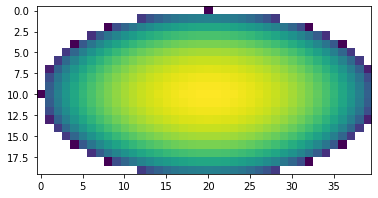

In [105]:
plt.imshow(z)

When rotating, we need to solve the implicit equation for $z$, but now with $x \rightarrow x^\prime, y \rightarrow y^\prime, z \rightarrow z^\prime$, where $[x^\prime,y^\prime,z^\prime]^T = R[x,y,z]^T$.

In other words: 
$$
1 = \frac{x^{\prime 2}}{a^a} + \frac{y^{\prime 2}}{b^2} + \frac{z^{\prime 2}}{c^2}
\\
= (Rxx \cdot x + Rxy \cdot y + Rxz \cdot z)^ 2 / a^2 + (Ryx \cdot x + Ryy \cdot y + Ryz \cdot z)^2 / b^2 + (Rzx \cdot x + Rzy \cdot y + Rzz \cdot z)^2/c^2 
$$



We can use the symbolic library `sympy` to simplify these equations, instead of doing them with pen and paper.

In [166]:
import sympy
from sympy import symbols, simplify, solve, var
# https://stackoverflow.com/questions/26787752/how-to-solve-a-simple-quadratic-equation-with-sympy
# https://docs.sympy.org/latest/modules/solvers/solveset.html#module-sympy.solvers.solveset

This example shows how to solve the get the solution to a quadratic equation in terms of the general constants, `a,b,c`. Note there are two solutions for the two roots.

In [169]:
y = 'a * x ** 2 + b * x + c'
x = var('x')
solve(y,  x )     # sympy solves Y(a,b,c,x) for x treating a, b, c as constants

[(-b - sqrt(-4*a*c + b**2))/(2*a), (-b + sqrt(-4*a*c + b**2))/(2*a)]

In [170]:
imp = 'x ** 2 / a**2 + y**2 / b**2 + z**2/c**2 - 1'
z = var('z')
sol = solve(imp,  z )
sol

[-c*sqrt(a**2*b**2 - a**2*y**2 - b**2*x**2)/(a*b),
 c*sqrt(a**2*b**2 - a**2*y**2 - b**2*x**2)/(a*b)]

We can copy paste the solution and turn it into code with `sqrt` -> `np.sqrt`

/Users/gw/miniconda2/envs/phys_aware_cryoem_202207/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  
/Users/gw/miniconda2/envs/phys_aware_cryoem_202207/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == "__main__":


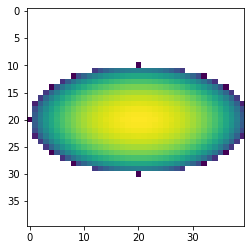

In [171]:
a=20
b=10
c=1
step_x = step_y = 1
max_axis = max(a,b)
x_mesh, y_mesh = np.meshgrid(np.arange(-max_axis,max_axis,step=step_x),np.arange(-max_axis,max_axis,step=step_y))
def proj_non_rot(x,y,a,b,c):
    z0 = -c*np.sqrt(a**2*b**2 - a**2*y**2 - b**2*x**2)/(a*b)
    z1 = c*np.sqrt(a**2*b**2 - a**2*y**2 - b**2*x**2)/(a*b)
    return np.abs(z0-z1)
plt.imshow(proj_non_rot(x_mesh,y_mesh,a,b,c))

Now we can extend this to rotate the ellipsoid in the xy plane (i.e. $Rzz = 1, Rxz = Ryz = Rzx = Ryz = 0$)

In [130]:
imp = '(Rxx*x + Rxy*y)** 2 / a**2 + (Ryx*x + Ryy*y)**2 / b**2 + z**2/c**2 - 1'
z = var('z')
solve(imp,  z ) 

[-c*sqrt(-Rxx**2*b**2*x**2 - 2*Rxx*Rxy*b**2*x*y - Rxy**2*b**2*y**2 - Ryx**2*a**2*x**2 - 2*Ryx*Ryy*a**2*x*y - Ryy**2*a**2*y**2 + a**2*b**2)/(a*b),
 c*sqrt(-Rxx**2*b**2*x**2 - 2*Rxx*Rxy*b**2*x*y - Rxy**2*b**2*y**2 - Ryx**2*a**2*x**2 - 2*Ryx*Ryy*a**2*x*y - Ryy**2*a**2*y**2 + a**2*b**2)/(a*b)]

/Users/gw/miniconda2/envs/phys_aware_cryoem_202207/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/Users/gw/miniconda2/envs/phys_aware_cryoem_202207/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


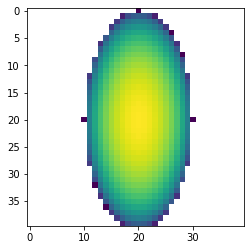

In [172]:
a=20
b=10
c=1
max_axis = max(a,b)
x_mesh, y_mesh = np.meshgrid(np.arange(-max_axis,max_axis,step=step_x),np.arange(-max_axis,max_axis,step=step_y))
R = np.zeros((3,3))
theta = np.deg2rad(90)
c_theta = np.cos(theta)
s_theta = np.sin(theta)
R[-1,-1] = 1
R[0,:2] = c_theta, -s_theta
R[1,:2] = s_theta, c_theta

def proj_2d_rot(x,y,a,b,c,R):
    Rxx,Rxy = R[0,:2]
    Ryx,Ryy = R[1,:2]
    z0 = -c*np.sqrt(-Rxx**2*b**2*x**2 - 2*Rxx*Rxy*b**2*x*y - Rxy**2*b**2*y**2 - Ryx**2*a**2*x**2 - 2*Ryx*Ryy*a**2*x*y - Ryy**2*a**2*y**2 + a**2*b**2)/(a*b)
    z1 =  c*np.sqrt(-Rxx**2*b**2*x**2 - 2*Rxx*Rxy*b**2*x*y - Rxy**2*b**2*y**2 - Ryx**2*a**2*x**2 - 2*Ryx*Ryy*a**2*x*y - Ryy**2*a**2*y**2 + a**2*b**2)/(a*b)
    return np.abs(z0-z1)
plt.imshow(proj_2d_rot(x_mesh,y_mesh,a,b,c,R))

In [131]:
imp = '(Rxx*x + Rxy*y + Rxz*z)** 2 / a**2 + (Ryx*x + Ryy*y + Ryz*z)**2 / b**2 + (Rzx*x + Rzy*y + Rzz*z)**2/c**2 - 1'
z = var('z')
solve(imp,  z ) 

[(-Rxx*Rxz*b**2*c**2*x - Rxy*Rxz*b**2*c**2*y - Ryx*Ryz*a**2*c**2*x - Ryy*Ryz*a**2*c**2*y - Rzx*Rzz*a**2*b**2*x - Rzy*Rzz*a**2*b**2*y - a*b*c*sqrt(-Rxx**2*Ryz**2*c**2*x**2 - Rxx**2*Rzz**2*b**2*x**2 - 2*Rxx*Rxy*Ryz**2*c**2*x*y - 2*Rxx*Rxy*Rzz**2*b**2*x*y + 2*Rxx*Rxz*Ryx*Ryz*c**2*x**2 + 2*Rxx*Rxz*Ryy*Ryz*c**2*x*y + 2*Rxx*Rxz*Rzx*Rzz*b**2*x**2 + 2*Rxx*Rxz*Rzy*Rzz*b**2*x*y - Rxy**2*Ryz**2*c**2*y**2 - Rxy**2*Rzz**2*b**2*y**2 + 2*Rxy*Rxz*Ryx*Ryz*c**2*x*y + 2*Rxy*Rxz*Ryy*Ryz*c**2*y**2 + 2*Rxy*Rxz*Rzx*Rzz*b**2*x*y + 2*Rxy*Rxz*Rzy*Rzz*b**2*y**2 - Rxz**2*Ryx**2*c**2*x**2 - 2*Rxz**2*Ryx*Ryy*c**2*x*y - Rxz**2*Ryy**2*c**2*y**2 - Rxz**2*Rzx**2*b**2*x**2 - 2*Rxz**2*Rzx*Rzy*b**2*x*y - Rxz**2*Rzy**2*b**2*y**2 + Rxz**2*b**2*c**2 - Ryx**2*Rzz**2*a**2*x**2 - 2*Ryx*Ryy*Rzz**2*a**2*x*y + 2*Ryx*Ryz*Rzx*Rzz*a**2*x**2 + 2*Ryx*Ryz*Rzy*Rzz*a**2*x*y - Ryy**2*Rzz**2*a**2*y**2 + 2*Ryy*Ryz*Rzx*Rzz*a**2*x*y + 2*Ryy*Ryz*Rzy*Rzz*a**2*y**2 - Ryz**2*Rzx**2*a**2*x**2 - 2*Ryz**2*Rzx*Rzy*a**2*x*y - Ryz**2*Rzy**2*a**2*y**2 + 

In [174]:
from scipy.spatial.transform import Rotation
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html

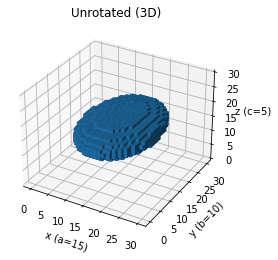

In [236]:
# prepare some coordinates
# max_dom = np.max([a,b,c])
# x, y, z = 2*np.indices((max_dom,max_dom,max_dom)) - max_dom
scale=5
a=3*scale
b=2*scale
c=1*scale
max_axis = np.max([a,b,c])
step_x = step_y = step_z = 1
x, y, z = np.meshgrid(
    np.arange(-max_axis,max_axis,step=step_x),
    np.arange(-max_axis,max_axis,step=step_y),
    np.arange(-max_axis,max_axis,step=step_z),
)


# draw cuboids in the top left and bottom right corners, and a link between
# them
ellipsoid = (x/a)**2 + (y/b)**2 + (z/c)**2
voxelarray = ellipsoid < 1

# set the colors of each object

# and plot everything
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(voxelarray)
ax.set_xlabel(f'x (a={a})')
ax.set_ylabel(f'y (b={b})')
ax.set_zlabel(f'z (c={c})')
ax.zaxis.set_rotate_label(False)
plt.title('Unrotated (3D)')

plt.show()


/Users/gw/miniconda2/envs/phys_aware_cryoem_202207/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


Text(0.5, 1.0, 'Rotated about [0 0 1] by 45 deg\n a=15,b=10,c=5')

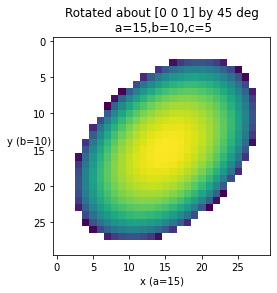

In [238]:
# a=20
# b=10
# c=5
step_x = step_y = 1
max_axis = np.max([a,b])
x_mesh, y_mesh = np.meshgrid(np.arange(-max_axis,max_axis,step=step_x),np.arange(-max_axis,max_axis,step=step_y))
axis = np.array([0,0,1])
deg=45
angle = np.deg2rad(deg)
r = Rotation.from_rotvec(angle*axis).as_matrix()

def proj_3d_rot(x,y,a,b,c,r):
    Rxx,Rxy,Rxz = r[0]
    Ryx,Ryy,Ryz = r[1]
    Rzx,Rzy,Rzz = r[2]
    # note that the z0 and z1 terms are very similar, except for a sign, so we can precompute the pieces 
    piece_1 = (-Rxx*Rxz*b**2*c**2*x - Rxy*Rxz*b**2*c**2*y - Ryx*Ryz*a**2*c**2*x - Ryy*Ryz*a**2*c**2*y - Rzx*Rzz*a**2*b**2*x - Rzy*Rzz*a**2*b**2*y)
    piece_2 = a*b*c*np.sqrt(-Rxx**2*Ryz**2*c**2*x**2 - Rxx**2*Rzz**2*b**2*x**2 - 2*Rxx*Rxy*Ryz**2*c**2*x*y - 2*Rxx*Rxy*Rzz**2*b**2*x*y + 2*Rxx*Rxz*Ryx*Ryz*c**2*x**2 + 2*Rxx*Rxz*Ryy*Ryz*c**2*x*y + 2*Rxx*Rxz*Rzx*Rzz*b**2*x**2 + 2*Rxx*Rxz*Rzy*Rzz*b**2*x*y - Rxy**2*Ryz**2*c**2*y**2 - Rxy**2*Rzz**2*b**2*y**2 + 2*Rxy*Rxz*Ryx*Ryz*c**2*x*y + 2*Rxy*Rxz*Ryy*Ryz*c**2*y**2 + 2*Rxy*Rxz*Rzx*Rzz*b**2*x*y + 2*Rxy*Rxz*Rzy*Rzz*b**2*y**2 - Rxz**2*Ryx**2*c**2*x**2 - 2*Rxz**2*Ryx*Ryy*c**2*x*y - Rxz**2*Ryy**2*c**2*y**2 - Rxz**2*Rzx**2*b**2*x**2 - 2*Rxz**2*Rzx*Rzy*b**2*x*y - Rxz**2*Rzy**2*b**2*y**2 + Rxz**2*b**2*c**2 - Ryx**2*Rzz**2*a**2*x**2 - 2*Ryx*Ryy*Rzz**2*a**2*x*y + 2*Ryx*Ryz*Rzx*Rzz*a**2*x**2 + 2*Ryx*Ryz*Rzy*Rzz*a**2*x*y - Ryy**2*Rzz**2*a**2*y**2 + 2*Ryy*Ryz*Rzx*Rzz*a**2*x*y + 2*Ryy*Ryz*Rzy*Rzz*a**2*y**2 - Ryz**2*Rzx**2*a**2*x**2 - 2*Ryz**2*Rzx*Rzy*a**2*x*y - Ryz**2*Rzy**2*a**2*y**2 + Ryz**2*a**2*c**2 + Rzz**2*a**2*b**2)
    piece_3 = (Rxz**2*b**2*c**2 + Ryz**2*a**2*c**2 + Rzz**2*a**2*b**2)
    z0 = (piece_1 - piece_2) / piece_3
    z1 = (piece_1 + piece_2) / piece_3
    return 2*piece_2/piece_3

plt.imshow(proj_3d_rot(x_mesh,y_mesh,a,b,c,r))
plt.xlabel(f'x (a={a})')
plt.ylabel(f'y (b={b})',rotation=0)
plt.title(f'Rotated about {axis} by {deg} deg\n a={a},b={b},c={c}')